![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Text Analysis of Beer Reviews**
Here we use pySpark to analyze the text in the commercial description and review text to create similarity scores between beers.  The scores can then be used for clustering and beer style identification or to find beers similar to what a user enjoys, as a recommendation service.

In [1]:
sc.defaultParallelism

2

### **Preliminaries**
#### We read in the allBeer.txt file and create an RDD consisting of lines.
#### We want to remove the header from the file, so the parseDataFileLine function identifies lines starting with 'beer_id' and applies a flag of 0, other lines with the correct number of fields are flagged 1, and incorrect lines are flagged -1.  The lines are split into arrays.

In [2]:
import re

def parseDatafileLine(datafileLine):
    ##Parse a line of the data file using the specified regular expression pattern
    splitArray = datafileLine.split("\t")
    for x in range(0,len(splitArray)):
        splitArray[x]=splitArray[x].replace("\"",'')
    #print len(splitArray)
    #print splitArray[0],
    splitArray[1],splitArray[2]
    if splitArray[0]=='beer_id':
        return (splitArray,0)
    elif len(splitArray)<>23:
        ##this is a failed parse
        return (splitArray,-1)
    else:
        return (splitArray, 1)

### Reading the file
#### We read the file into three rdds by first parsing the file as above, the header rdd, failed rdd and the valid rdd.  Print the header names so we can remember what fields we're dealing with and in what order.

In [3]:
import sys
import os

baseDir = os.path.join('')
allBeer_Path = 'AllBeerBig.txt'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    #Parse a data file returns a RDD of parsed lines
    
    return (sc
            .textFile(filename, 4)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    ##Load a data file, returns a RDD of parsed valid lines
    
    filename = os.path.join(baseDir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    header = (raw
              .filter(lambda s: s[1]==0)
             .map(lambda s:s[0])
             )
    headerDict={}
    for line in header.take(1):
        for x in range(0,len(line)):
            headerDict[x]=line[x]
            print x,line[x]
            
    rawLines = raw.count()
    validLines = valid.count()
    failedLines = failed.count()
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path, rawLines, validLines,failedLines)
    return valid, headerDict
    
allBeer,headers = loadData(allBeer_Path)
#allReviews = loadData(allReviews_Path)

0 beer_id
1 beer_name
2 brewer_name
3 beer_style
4 distribution
5 brewery_location
6 commercial_desc
7 RATINGS: 
8 MEAN (/5)
9 WEIGHTED AVG
10 EST. CALORIES
11 ABV (%)
12 IBU
13 SCORE
14 AROMA (/10)
15 APPEARANCE(/5)
16 TASTE(/10)
17 PALATE(/5)
18 OVERALL(/20)
19 reviewer_name
20 review_location
21 review_date
22 review_content
AllBeerBig.txt - Read 620388 lines, successfully parsed 620387 lines, failed to parse 0 lines


### Let's examine the first few entries of a sample of 5 lines to check if things look ok.

In [4]:
sampleArray=allBeer.takeSample(False,5,1)
for line in sampleArray:
    print len(line)
    print 'allBeer: %s, %s, %s, %s, %s\n' % (line[0], line[1], line[2],line[3],line[4])

23
allBeer: 63103, , Valkyrie Brewing Company, Witbier, distribution unknown

23
allBeer: 107308, , BrewDog, Weizen Bock, distribution unknown

23
allBeer: 108299, , Brouwerij De Vriendschap, German Hefeweizen, distribution unknown

23
allBeer: 68129, , Bear Republic Brewing Company, Heller Bock, Local Distribution

23
allBeer: 76919, , Back Street Brewery, Belgian Strong Ale, distribution unknown



### Clean the Data
#### Since we're heavily dependent on the number of reviews each individual gives we will need to remove users who have an unacceptably low number, since we're dividing into training and test sets and the goal is to predict an order we should have at least 3 beers per user in the test set.  If we split 80/20 this means at least 12 beer reviews overall.  We are also going to immediately purge any blank reviews.

In [5]:
##Purge blank reviews and make (k,V) pairs
nonEmpty = allBeer.map(lambda x:(x[19],x)).filter(lambda (x,y):y[22]!='')
##Convert strings to floats for 13 through 18
def convertStrings(inputList,indexList):
    outList = []
    for x in range(0,len(inputList)):
        if x in indexList:
            outList.append(float(inputList[x]))
        else:
            outList.append(inputList[x])
    return outList
convIndicies=[13,14,15,16,17,18]
convertedToFloats = nonEmpty.map(lambda (x,y):(x,convertStrings(y,convIndicies)))

##Remove users with less than 12 reviews.
def removeUsers(inputRDD,minReviews):
    countPerUser = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    outRDD = inputRDD.join(countPerUser).filter(lambda (x,(y,z)):z>=minReviews)
    return outRDD.map(lambda (x,(y,z)):(x,y))
beerByUser = removeUsers(convertedToFloats,12).cache()
print "There are %d users in the dataset." % beerByUser.map(lambda (x,y):x).distinct().count()
print "There are %d beers in the dataset." % beerByUser.map(lambda (x,y):y[0]).distinct().count()
print "There are %d reviews in the dataset." % beerByUser.count()

There are 4005 users in the dataset.
There are 99891 beers in the dataset.
There are 591212 reviews in the dataset.


### Let's take a look at the distributions for some of the scoring metrics we have.

In [6]:
from math import sqrt
numReviews = beerByUser.count()
basicStatDict={}
for colCount in range(13,19):
    sumCol = beerByUser.map(lambda (x,y):float(y[colCount])).reduce(lambda a,b:a+b)
    meanCol = sumCol/numReviews
    sumColDev = beerByUser.map(lambda (x,y):(float(y[colCount])-meanCol)**2).reduce(lambda a,b:a+b)
    stdDev = sqrt(sumColDev/numReviews)
    basicStatDict[headers[colCount]]=(meanCol,stdDev)
    print "%s Mean: %f , Std Dev: %f" % (headers[colCount], meanCol,stdDev)


SCORE Mean: 3.287936 , Std Dev: 0.576874
AROMA (/10) Mean: 6.451894 , Std Dev: 1.308588
APPEARANCE(/5) Mean: 3.406499 , Std Dev: 0.705807
TASTE(/10) Mean: 6.509156 , Std Dev: 1.334516
PALATE(/5) Mean: 3.279037 , Std Dev: 0.724682
OVERALL(/20) Mean: 13.232264 , Std Dev: 2.699790


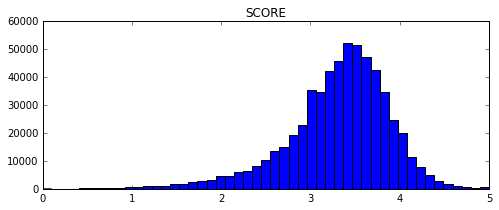

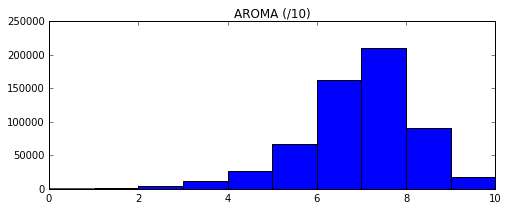

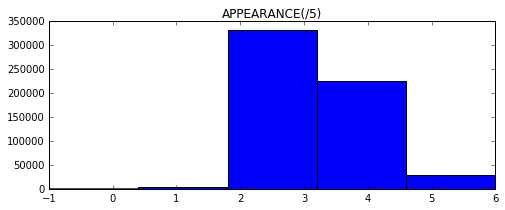

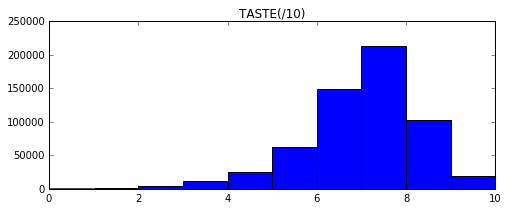

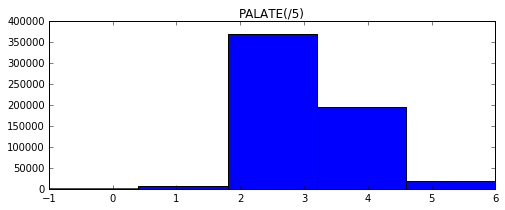

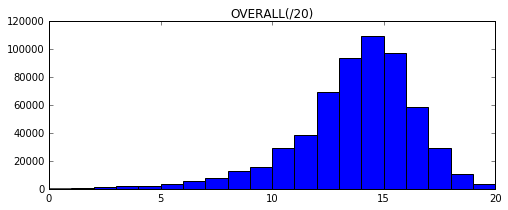

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
buckets = [49,10,5,10,5,20]
ranges = [(0,5),(0,10),(-1,6),(0,10),(-1,6),(0,20)]
for colCount in range(13,19):
    scoreValues = beerByUser.map(lambda (x,y): float(y[colCount])).collect()
    fig = plt.figure(figsize=(8,3))
    plt.title(headers[colCount])
    plt.hist(scoreValues, buckets[colCount-13], range=ranges[colCount-13],log=False)
pass

### Scale the reviews:
#### Each user has a different way of scoring beers, some people judge more harshly than others.  In order to even out these scores, we get get statistics for each user and adjust their scores to fit a common distribution.  In this particular case we use a normal distribution for it's simplicity to execute.  Users with 1 or less reviews will have a standard deviation of 0, in which case we substitute 1 to ensure the division when obtaining z-scores we will not divide by zero.

In [8]:
##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def replaceZeroes(inputValue,replacementValue):
    if inputValue == 0:
        inputValue = replacementValue
    return inputValue

def subtractFromColumn(inputList,columnToChange,subtractAmount):
    inputList[columnToChange]=float(inputList[columnToChange])-subtractAmount
    return inputList

def divideColumn(inputList,columnToChange,divisor):
    inputList[columnToChange]=float(inputList[columnToChange])*2.5/divisor
    return inputList


def normalizeScoreByKey(inputRDD,scoreColumn):
    ##Takes in RDD of (key,array) and 
    ##returns RDD of (key,array with scoreColumn normalized)
    sumScores = inputRDD.map(lambda (x,y):(x,float(y[scoreColumn]))).reduceByKey(lambda a,b:a+b)
    countScoresPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    averageScores = sumScores.join(countScoresPerKey).map(lambda (x,y):(x,y[0]/y[1]))
    centredScores = inputRDD.join(averageScores).map(lambda (x,(y,z)):(x,subtractFromColumn(y,scoreColumn,z)))
    centredScoresSquaredSum = centredScores.map(lambda (x,y):(x,y[scoreColumn]*y[scoreColumn])).reduceByKey(lambda a,b:a+b)
    centredScoresSquaredSumAndCount = centredScoresSquaredSum.join(countScoresPerKey)
    stdDeviationByKey = centredScoresSquaredSumAndCount.map(lambda (x,y):(x,sqrt(y[0]/y[1])))
    ##Just in case they have 0 variance, to get z-score div by zero error would occur
    stdDeviationByKeyNoZero = stdDeviationByKey.map(lambda (x,y):(x,replaceZeroes(y,1)))
    normalizedRDD = centredScores.join(stdDeviationByKeyNoZero).map(lambda (x,(y,z)):(x,divideColumn(y,scoreColumn,z)))
    return normalizedRDD

def centreScoreByKey(inputRDD,scoreColumn):
    ##Takes in RDD of (key,array) and 
    ##returns RDD of (key,array with scoreColumn normalized)
    sumScores = inputRDD.map(lambda (x,y):(x,float(y[scoreColumn]))).reduceByKey(lambda a,b:a+b)
    countScoresPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    averageScores = sumScores.join(countScoresPerKey).map(lambda (x,y):(x,y[0]/y[1]))
    centredScores = inputRDD.join(averageScores).map(lambda (x,(y,z)):(x,subtractFromColumn(y,scoreColumn,z)))
    return centredScores

##Normalize the Scores
#beerNormalized = normalizeScoreByKey(beerByUser,13)
##Normalize the rest of the ratings
#cScores = normalizeScoreByKey(normalizedScores,14)
#cScores = normalizeScoreByKey(beerNormA,15)
#cScores = normalizeScoreByKey(beerNormB,16)
#cScores = normalizeScoreByKey(beerNormC,17)
#beerNormalized = centreScoreByKey(cScores,18).cache()

##Don't Normalize the scores
beerNormalized = beerByUser

print beerNormalized.takeSample(False,5,4)

[(u'holdenn', [u'47066', u'Three Floyds Spazzerak!', u'Three Floyds Brewing Company', u'American Strong Ale', u'Local Distribution', u'Munster , Indiana USA', u'Alpha King blended with Robert the Bruce then aged in a bourbon barrel with star anise and orange peel', u'18.000', u'2.620', u'2.650', u'270.000', u'9.000', u'40.000', 3.1, 7.0, 3.0, 6.0, 3.0, 12.0, u'holdenn', u'Chicago, Illinois, USA ', u'AUG 21, 2012', u'FoBAB 2011. Murky brown with a thin head. Wow that\ufffds a bag of dad\ufffds black licorice right there. So much anise. Bitter anise flavors. Thin black licorice water. I like black licorice, but not in this beer. Not good. 7/3/6/3/12 ']), (u'Garrold', [u'56922', u'', u'Coastal', u'Golden Ale/Blond Ale', u'Regional Distribution', u'Redruth, England', u'Cask; Regular.', u'11.000', u'3.330', u'3.220', u'129.000', u'4.300', u'', 3.4, 6.0, 3.0, 7.0, 3.0, 15.0, u'Garrold', u'Sheffield, South Yorkshire, ENGLAND ', u'APR 17, 2015', u'Bottle. Dram Shop, Sheffield. Clear, orang gol

### Now we'll split the data into a training set (80%),  test set (20%) 
#### This is slightly complicated by the fact that we want to split each user into 80/20, not the set of reviews as a whole.  We will take advantage of stratified sampling in Spark, grouping the reviews by the user name, then sampling by key.  To get the unused data we employ subtractByKey using a compound key of the username and the beer_id, guaranting uniqueness.

In [9]:
##Using the allBeer array, take stratified sample, and remove blank reviews.
sampleKeys = beerNormalized.keys().collect()
fractions={}
for k in sampleKeys:
    fractions[k]=0.8
    
beerTrain = beerNormalized.sampleByKey(False,fractions).cache()
beerTrainKeyed = beerTrain.map(lambda (x,y):(y[0]+y[19],y))
beerTest = beerNormalized.map(lambda (x,y):(y[0]+y[19],y)).subtractByKey(beerTrainKeyed).map(lambda (x,y):(y[19],y)).cache()
#beerTestAndVal = beerNormalized.map(lambda (x,y):(y[0]+y[19],y)).subtractByKey(beerTrainKeyed)
#sampleKeys = beerTestAndVal.keys().collect()
#fractions={}
#for k in sampleKeys:
#    fractions[k]=0.5
#beerTestCombinedKey = beerTestAndVal.sampleByKey(False,fractions)
#beerTest = beerTestCombinedKey.map(lambda (x,y):(y[19],y)).cache()
#beerVal = beerTestAndVal.subtractByKey(beerTestCombinedKey).map(lambda (x,y):(y[19],y)).cache()
bNC = beerNormalized.count()
bTrC = float(beerTrain.count())
bTeC = float(beerTest.count() )
#bVC = float(beerVal.count())
print "Total reviews: %f" % float(bNC)
print "Training set: %f  Percentage: %f" %(bTrC,bTrC/bNC)
print "Test set: %f  Percentage: %f" %(bTeC,bTeC/bNC)
#print "Validation set: %f  Percentage: %f" %(bVC,bVC/bNC)

Total reviews: 591212.000000
Training set: 472784.000000  Percentage: 0.799686
Test set: 118428.000000  Percentage: 0.200314


### Let's examine the results with a couple of random users.

In [10]:
from numpy.random import random_integers
##find a random user and print out the train and test set.
randomUsers = random_integers(1,len(sampleKeys),2)
sampleUserReviewCount = beerNormalized.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[0]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

sampleUserReviewCount = beerNormalized.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[1]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

The user OleR has 193 reviews, split into 157 Train and 36 Test
The user mikem409 has 268 reviews, split into 216 Train and 52 Test


### Let's find each user's favourite styles, if they haven't reviewed beers in a particular style substitute the average for that style across all users.

In [11]:
beerStyles = beerByUser.map(lambda (x,y):y[3]).distinct().collect()
styleDict={}
for style in beerStyles:
    styleDict[style]=(0,0)  ##count and sum
def reduceIntoDict(a,b):
    #a and b should be dict of {style:(rating,1)}
    combinedDict={}
    for element in a:
        if element in b:
            combinedDict[element]=(a[element][0]+b[element][0],a[element][1]+b[element][1])
        else:
            combinedDict[element]=a[element]
    for element in b:
        if element in combinedDict:
            pass
        else:
            combinedDict[element]=b[element]
    return combinedDict

def convertDict(inputDict,styleDict,avgDict):
    outDict={}
    sumBeers=0
    for style in inputDict:
        sumBeers +=inputDict[style][1]
    
    for style in styleDict:
        if style in inputDict:
            outDict[style]=(inputDict[style][0]/inputDict[style][1],float(inputDict[style][1])/sumBeers)
        elif style in avgDict:
            outDict[style]=(avgDict[style],0)
        else:
            outDict[style]=(0,0)
    return outDict
countPerSum = beerTrain.map(lambda (x,y):(y[3],1)).reduceByKey(lambda a,b:a+b)
avgPerStyle = beerTrain.map(lambda (x,y):(y[3],y[13])).reduceByKey(lambda a,b:a+b).join(countPerSum).map(lambda (x,(y,z)):(x,y/z)).collect()
avgPerStyleDict = {a[0]:a[1] for a in avgPerStyle}
print avgPerStyleDict
styleSums = beerTrain.map(lambda(x,y):(x,{y[3]:(y[13],1)})).reduceByKey(reduceIntoDict)
styleAvgAndFreq=styleSums.map(lambda (x,y):(x,convertDict(y,styleDict,avgPerStyleDict)))
print styleAvgAndFreq.takeSample(False,1,5)


{u'Spice/Herb/Vegetable': 3.2128278629783567, u'Sak\ufffd - Infused': 2.9163934426229505, u'Czech Pilsner (Sv\u011btl\ufffd)': 3.09342033713975, u'Abt/Quadrupel': 3.565632754342432, u'Sak\ufffd - Ginjo': 3.4027777777777777, u'Cream Ale': 3.06762629005975, u'Pilsener': 3.0063283875727516, u'Polotmav\ufffd': 2.9823529411764707, u'Abbey Dubbel': 3.2983060109289615, u'Sweet Stout': 3.4672277227722788, u'Scotch Ale': 3.463495838287753, u'Specialty Grain': 3.2837774957698818, u'Ice Cider/Ice Perry': 4.0119363395225465, u'Dunkelweizen': 3.207519640852974, u'Imperial Pils/Strong Pale Lager': 2.941351766513057, u'Sak\ufffd - Nigori': 3.529885057471264, u'Sak\ufffd - Tokubetsu': 3.033333333333333, u'Amber Ale': 3.1417335834896813, u'Belgian Ale': 3.248518395205592, u'Imperial Stout': 3.7807677518584963, u'Perry': 3.1082920792079203, u'Malt Liquor': 2.2624999999999997, u'Doppelbock': 3.3778197674418586, u'Premium Bitter/ESB': 3.2175631885936498, u'Scottish Ale': 3.2243292682926827, u'Sahti/Gotlan

### Spearman Correlation
#### Let's implement a Spearman Rank Function so we can have a metric to compare the order of two lists.

In [12]:
### ToDo: lookup Kendall Tau, Rank Biased Overlap (RBO), maybe mean squared error??
from scipy.stats import spearmanr
from scipy.stats.stats import rankdata
from scipy.stats import pearsonr
import math

### Need to implement a function which will take the results from the cosSim RDD and spit out
### average?? spearman.

def catTuplesToLists(tupleOne,tupleTwo):
    if len(tupleOne)==len(tupleTwo):
        a=[]
        for x in range(0,len(tupleOne)):
            firstEle=tupleOne[x]
            if type(firstEle) is not list: firstEle = [ tupleOne[x] ]
            secondEle=tupleTwo[x]
            if type(secondEle) is not list: secondEle = [ tupleTwo[x] ]
            a.append(firstEle+secondEle)
        return tuple(a)
    else:
        raise ValueError('Two tuples are not the same dimensions')

def mattSpearman(listOne,listTwo):
    if type(listOne) is list and type(listTwo) is list:
        lO=len(listOne)
        if lO==len(listTwo) and lO>1:
            lOR = rankdata(listOne)
            lTR = rankdata(listTwo)
            print lOR
            print lTR
            dSquared=0
            for x in range(0,lO):
                dSquared+=(lOR[x]-lTR[x])**2
            return 1-6*dSquared/lO/(lO**2-1)
        else:
            raise ValueError("Both Lists must be same length and greater than one.")
    else:
        return 0

def reduceNaN(a,b):
    if math.isnan(a):
        a=0
    if math.isnan(b):
        b=0
    return a+b

def avgSpearman(inputRDD):
    #So the problem here is trying to output two lists which have the scores in the same order.
    #Write custom reduce function, catTuplesToLists
    convertedToLists = inputRDD.reduceByKey(catTuplesToLists)
    #print convertedToLists.take(5)
    filteredLists = convertedToLists.filter(lambda (x,y):type(y[1]) is list)
    #print filteredLists.take(5)
    spearmanByKey = filteredLists.map(lambda (x,y):(x,mattSpearman(y[1],y[2]), len(y[1])))
    #print spearmanByKey.take(5)
    spearmanOnly = spearmanByKey.map(lambda (x,y,z):y)
    #print spearmanOnly.count()
    #print spearmanOnly.take(5)
    avgSpearmanRho=spearmanOnly.reduce(lambda a,b:a+b)/spearmanOnly.count()
    return avgSpearmanRho

def maxNPerKey(inputRDD,N):
    ##Take a random N lines per Key, return RDD with N or less entries in each key.
    entriesPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b).collect()
    fractions={}
    for k in entriesPerKey:
        if k[1]<=N:
            fractions[k[0]]=1
        else:
            fractions[k[0]]=N/k[1]
    return inputRDD.sampleByKey(False,fractions)
    

### And we'll use the user's average per style to predict the order of the test ratings:

In [13]:
styleWithStylePref=beerTest.map(lambda (x,y):(x,(y[0],y[3],y[13]))).join(styleAvgAndFreq)
styleOnlyPredAvg = styleWithStylePref.map(lambda (x,((a,b,c),d)):(x,(a,c,d[b][0])))
styleOnlyPredMax10 = maxNPerKey(styleOnlyPredAvg,10)
print styleOnlyPredMax10.takeSample(False,2,10)
print avgSpearman(styleOnlyPredMax10)
MSE = styleOnlyPredMax10.map(lambda (x,(a,b,c)): (b - c)**2).mean()
print MSE

[(u'Unm4rk3d', (u'38664', 3.9, 3.6)), (u'ibrubeer', (u'77838', 3.5, 3.3604606130520756))]
0.299345807701
0.408901513337


### And again, but this time using the user's frequency of reviewing each style

In [14]:
styleWithStylePref=beerTest.map(lambda (x,y):(x,(y[0],y[3],y[13]))).join(styleAvgAndFreq)
styleOnlyPred = styleWithStylePref.map(lambda (x,((a,b,c),d)):(x,(a,c,d[b][1])))
styleOnlyPredMax10 = maxNPerKey(styleOnlyPred,10)
print styleOnlyPred.takeSample(False,2,10)
print avgSpearman(styleOnlyPredMax10)

[(u'mr_h', (u'39780', 3.4, 0.2759084791386272)), (u'beastiefan2k', (u'14688', 3.2, 0.012232415902140673))]
0.198746240602


#### We can see that the style average score gives a better Spearman correlation than the frequency.  This makes sense as review frequency is not the same as drinking frequency.
### What about their favourite brewery?

In [15]:
breweries = beerByUser.map(lambda (x,y):y[2]).distinct().collect()
brewerDict={}
for brewer in breweries:
    brewerDict[brewer]=(0,0)  ##count and sum
    
countPerSum = beerTrain.map(lambda (x,y):(y[2],1)).reduceByKey(lambda a,b:a+b)
avgPerBrewer = beerTrain.map(lambda (x,y):(y[2],y[13])).reduceByKey(lambda a,b:a+b).join(countPerSum).map(lambda (x,(y,z)):(x,y/z)).collect()
avgPerBrewerDict = {a[0]:a[1] for a in avgPerBrewer}
print avgPerBrewerDict
brewerSums = beerTrain.map(lambda(x,y):(x,{y[2]:(y[13],1)})).reduceByKey(reduceIntoDict)
brewerAvgAndFreq=brewerSums.map(lambda (x,y):(x,convertDict(y,brewerDict,avgPerBrewerDict)))
print brewerAvgAndFreq.takeSample(False,1,5)

{u'Kingdom Brewing': 3.075, u'Wards Cidery (The View Winery)': 3.1333333333333337, u'Croft Brewing Company': 3.385714285714286, u'Milk & Honey Ciders': 3.3, u'Het Klaverblad Amersfoort V.O.F.': 2.9421052631578952, u'Hop Dogma Brewing Company': 3.4124999999999996, u'Fair State Brewing Cooperative': 3.69041095890411, u'Efes Karaganda': 2.0999999999999996, u'La Ferme d\ufffdHotte': 3.5555555555555554, u'Hops Haven Brew Haus/Port Washington Brewing Co.': 3.125, u'Homestead Beer Co.': 3.242857142857143, u'Bargara Brewing Company': 2.95, u'Wyszak': 3.3249999999999997, u'Blind Tiger': 3.358139534883721, u'Red Fox': 3.126666666666667, u'Lost Nation Brewing': 3.565909090909091, u'Three Saints Cider': 3.1, u'Brauerei M\ufffdhlbauer': 3.1166666666666667, u'SlapShot Brewing Co.': 3.616, u'Rhymney': 3.2062500000000003, u'Flagstaff Brewing Company': 3.1925373134328354, u'Neues Torgauer Brauhaus': 2.7960000000000003, u'Wooden Skiff Brewing': 3.0, u'McRitchie Ciderworks': 3.1, u'ALEhouse': 3.156, u'Ho

### And let's predict the user's preference based on brewery

In [16]:
brewerWithBrewerPref=beerTest.map(lambda (x,y):(x,(y[0],y[2],y[13]))).join(brewerAvgAndFreq)
brewerOnlyPredAvg = brewerWithBrewerPref.map(lambda (x,((a,b,c),d)):(x,(a,c,d[b][0])))
brewerOnlyPredMax10 = maxNPerKey(brewerOnlyPredAvg,10)
print brewerOnlyPredMax10.takeSample(False,2,10)
print avgSpearman(brewerOnlyPredMax10)
MSE = brewerOnlyPredMax10.map(lambda (x,(a,b,c)): (b - c)**2).mean()
print MSE

[(u'Unm4rk3d', (u'38664', 3.9, 3.298305084745763)), (u'ibrubeer', (u'77838', 3.5, 3.8499999999999996))]
0.345573108909
0.358279058292


### So the brewery also has a positive spearman correlation with the user's score, and it's a bit stronger than the style.

### ALS for collaborative filtering
#### The built in collaborative filtering methodology in Mllib is ALS (Alternating Least Squares).  We will use this with the user input score to generate a model which groups users according to their mutual like or dislike of beers based on their score.  This is then used to predict a score for beers which the user has not seen before, but the group has.

#### We need to add a unique number to each user name, as the Mllib ALS module doesn't support text user names.  We do this by creating a list of unique names and assigning a number, and creating a dictionary to reference this in the future.

In [17]:
##First need to make integer usernames since ALS doesn't support text userIDs.
##Solution: create a dictionary
#print beerTrain.take(5)
userList = allBeer.map(lambda x: x[19]).collect()
userList = list(set(userList))
userDict={}
for x in range(0,len(userList)):
    userDict[userList[x]]=x
print userDict.items()[0:5]
print len(userDict)

[(u'nazzty', 0), (u'Manetsdad', 2), (u'Bewitched', 3), (u'Nejhleader', 13431), (u'CObiased', 5)]
16108


#### Here I'm using a rank of 130 and numIterations equal to 40.  I would prefer to run more, but due to hardware limitations this is as far as I can push it.

In [19]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Reshape data
ratings = beerTrain.map(lambda l: Rating(int(l[1][0]), int(userDict[l[0]]), float(l[1][13])))
#print ratings.takeSample(False,5,1)
# Build the recommendation model using Alternating Least Squares
rank = 130
numIterations = 40
model = ALS.train(ratings, rank, numIterations,0.01)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Training Mean Squared Error = " + str(MSE))

# Save and load model
#model.save(sc, "normscoreALS")
#sameModel = MatrixFactorizationModel.load(sc, "scoreALS")

##Evaluate the model on the test data
testRatings = beerTest.map(lambda l: Rating(int(l[1][0]), int(userDict[l[0]]), float(l[1][13])))
#print testRatings.takeSample(5,5,False)
testdata = testRatings.map(lambda p: (p[0],p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testRatings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
#print ratesAndPreds.takeSample(False,5,1)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Test Mean Squared Error = " + str(MSE))

Training Mean Squared Error = 0.000499890047148
Test Mean Squared Error = 0.210551662654


### And again, let's see if we can predict the user's rating based solely on ALS collaborative filtering.

In [20]:
MSE = ratesAndPreds.map(lambda r: (r[1][0] - round(r[1][1],1))**2).mean()
print MSE
predsByUser = ratesAndPreds.map(lambda r: (r[0][1],(r[0][0],r[1][0],round(r[1][1],1))))
print "The Spearman correlation using collaborative filtering using only scores is %f" % avgSpearman(predsByUser)
max10 = maxNPerKey(predsByUser,10)
print "The Spearman correlation using collaborative filtering using only scores with a menu of 10 beers is %f" % avgSpearman(max10)

0.211196231451
The Spearman correlation using collaborative filtering using only scores is 0.519316
The Spearman correlation using collaborative filtering using only scores with a menu of 10 beers is 0.482260


In [21]:
MeanError = max10.map(lambda(x,(a,b,c)):(b-c)).mean()
print MeanError

0.15265443063


### So we can see here that the spearman correlation isn't so bad at 0.525 for all the beers in the test set and 0.48 for a reduced 10 item menu.  The MSE is 0.202, corresponding to an RMSE of 0.450.  Also the mean error is 0.163, which indicates that there is some bias to the low side.

### As a guide, if we simulate a 0.450 RMSE and check the non biased Spearman Correlation below we get a Spearman of 0.67, showing that the bias is throwing off our ranking.  In order to make a better prediction we have to both tighten up the RMSE and get rid of the bias.

In [22]:
import random
plusMinus = max10.map(lambda (x,(a,b,c)):(x,(a,b,b+random.randrange(-1,2,2)*0.450)))
MSE = plusMinus.map(lambda (x,(a,b,c)): (b-c)**2).mean()
print("Test Mean Squared Error = " + str(MSE))
print avgSpearman(plusMinus)

Test Mean Squared Error = 0.2025
0.679021577381


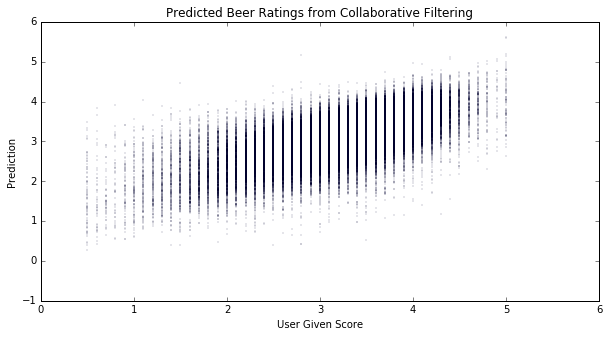

In [23]:
%matplotlib inline

ratingsXpredictionY = ratesAndPreds.map(lambda r: (r[1][0],r[1][1])).collect()
ratingsX=[x[0] for x in ratingsXpredictionY]
predictionY=[x[1] for x in ratingsXpredictionY]
fig = plt.figure(figsize=(10,5))
plt.title("Predicted Beer Ratings from Collaborative Filtering")
plt.scatter(ratingsX,predictionY,s=1,alpha=0.1)
plt.xlabel("User Given Score")
plt.ylabel("Prediction")
plt.xlim([0,6])
plt.show()
pass

### Step 1: Making Bags of Words
#### We can take the commercial descriptions and the user input text reviews and convert them into bags of words, we can then treat each word as a feature.  
#### We should take out stopwords before we do this, to avoid unfairly weighting reviews based on words which don't contribute much meaning, such as "the", "a", "is", "which", etc.

In [24]:
stopfile = os.path.join(baseDir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
testString = "This is a test of the tf function.  It should return non stopword frequencies frequency sourness"
print 'These are the stopwords: %s' % stopwords
split_regex = r'\W+'

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def tokenize(string):
    ##takes in a string and tokenizes it, removing stopwords, returns list
    simple=filter(None,re.split(split_regex,string.lower()))
    simple = [wnl.lemmatize(i) for i in simple]
    return [i for i in simple if i not in stopwords]

print tokenize(testString)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

In [25]:
##6 commercial description
##22 user input review
##make an RDD where the user_id is the key, and the value is 2 arrays of tokens 
##and the original line
def checkEmpty(inputList):
    if not inputList:
        return False
    else:
        return True
    
beerTrainToToken = beerTrain.map(lambda (x,y):(y[19],(tokenize(y[6]),tokenize(y[22]),y))).filter(lambda (x,(a,b,c)):checkEmpty(c))

def countTokens(textRDD,reviewTRUE):
    ## Count and return the number of tokens
    if reviewTRUE==True:
        return textRDD.map(lambda (x,y):len(y[1])).reduce(lambda a,b:a+b)
    else:
        return textRDD.map(lambda (x,y):len(y[0])).reduce(lambda a,b:a+b)

print 'There are %s tokens in the commercial descriptions' % countTokens(beerTrainToToken,False)
print 'There are %s tokens in the reviews' % countTokens(beerTrainToToken,True)

There are 11080261 tokens in the commercial descriptions
There are 15760668 tokens in the reviews


### Naive Bayes
#### Now it gets a little tricky, we want to predict the score a specific user will give to a beer based on the words in the reviews.  We will need to train a Naive Bayes classifier for each user, then apply it to the test reviews.  Also since we're using so many classes, it's not very informative to pick just the highest probability class, in the nltk naive bayes classifier there is a method to return the probability distribution of all classes, which we can then multiply by the score to get the expectation value of the user's score.

### First load up the features from the previous analysis.

In [26]:
featuresFileName = os.path.join(baseDir, "sortedFeatures.txt")
def parseFeatFile(inputLine):
    word,wscore=inputLine.split(",")
    return word,wscore
features = sc.textFile(featuresFileName, 1).map(parseFeatFile).cache()
featureList = features.map(lambda (x,y):x).collect()
x = 400
featTopX = featureList[:x]+featureList[-x:]
print featTopX[:20]
print featTopX[-20:]

[u'corn', u'watery', u'water', u'lager', u'bad', u'metallic', u'bland', u'cardboard', u'nothing', u'boring', u'artificial', u'stale', u'infected', u'weak', u'grainy', u'pale', u'much', u'weird', u'awful', u'unpleasant']
[u'awesome', u'whiskey', u'great', u'grapefruit', u'complex', u'full', u'balanced', u'oak', u'smooth', u'tropical', u'excellent', u'delicious', u'coconut', u'rich', u'nice', u'black', u'vanilla', u'coffee', u'chocolate', u'bourbon']


### Now make dictionaries for each beer

In [27]:
from nltk.classify import NaiveBayesClassifier

def generateDict(bagOfWords,allowedWords):
    outDict={}
    for word in allowedWords:
        outDict[word]=0
    for word in bagOfWords:
        if word in outDict:
            outDict[word]+=1
    return outDict
            
allWordsPerBeer = beerTrainToToken.map(lambda (x,(a,b,c)): (c[0],b)).reduceByKey(lambda a,b:a+b)
dictPerBeer = allWordsPerBeer.map(lambda (x,a):(x,generateDict(a,featTopX)))
print dictPerBeer.takeSample(False,3,1)

[(u'36194', {u'horrible': 0, u'vile': 0, u'ale': 0, u'yellow': 4, u'enjoyable': 0, u'mild': 1, u'messy': 0, u'woody': 0, u'mill': 0, u'bomber': 0, u'hate': 0, u'milk': 0, u'poorly': 0, u'layers': 0, u'grape': 0, u'peanut': 0, u'snifter': 0, u'disgusting': 0, u'unpleasant': 0, u'melon': 0, u'sorry': 0, u'brown': 0, u'lack': 1, u'premium': 0, u'worse': 0, u'dessert': 0, u'blanket': 0, u'brownie': 0, u'worst': 0, u'figs': 0, u'stays': 0, u'awful': 0, u'bubbles': 0, u'impressive': 0, u'doesn': 0, u'level': 0, u'watered': 0, u'minimal': 0, u'small': 1, u'loads': 0, u'round': 0, u'farmhouse': 0, u'cookies': 0, u'pledge': 0, u'miller': 0, u'almond': 0, u'radler': 0, u'kolsch': 0, u'past': 0, u'dishwater': 0, u'rate': 0, u'currant': 0, u'dried': 0, u'go': 0, u'pass': 0, u'shandy': 0, u'odd': 0, u'port': 0, u'windex': 0, u'even': 0, u'guava': 0, u'adds': 0, u'opaque': 0, u'slight': 0, u'espresso': 0, u'musty': 1, u'oaky': 0, u'rotten': 0, u'abv': 0, u'shared': 1, u'zesty': 0, u'seemed': 0, u'li

In [28]:
##join user and rating to beer and dictionary, map to user,(dictionary,rating)
ratingAndDictPerUser = beerTrainToToken.map(lambda (x,(a,b,c)):(c[0],(x,c[13]))).join(dictPerBeer).map(lambda (x,((a,b),c)):(a,[(c,b)]))
##test to see if the format is good.
ratingAndDictListPerUser = ratingAndDictPerUser.reduceByKey(lambda a,b:a+b)
print ratingAndDictListPerUser.takeSample(False,2,1)
#ratingAndDictListPerUser.take(1)
#classifier = NaiveBayesClassifier.train(trainfeatsAndClasses)

[(u'hrabren', [({u'horrible': 0, u'vile': 0, u'ale': 0, u'yellow': 0, u'enjoyable': 1, u'mild': 0, u'messy': 0, u'woody': 1, u'mill': 0, u'bomber': 0, u'hate': 0, u'milk': 0, u'poorly': 0, u'layers': 0, u'grape': 0, u'peanut': 0, u'description': 0, u'rubber': 0, u'snifter': 0, u'disgusting': 0, u'unpleasant': 0, u'melon': 0, u'sorry': 0, u'brown': 0, u'lack': 0, u'premium': 0, u'worse': 0, u'dessert': 0, u'blanket': 0, u'penny': 0, u'brownie': 0, u'worst': 0, u'figs': 0, u'stays': 0, u'awful': 0, u'bubbles': 0, u'impressive': 0, u'doesn': 0, u'level': 0, u'watered': 0, u'minimal': 1, u'small': 1, u'loads': 0, u'round': 0, u'farmhouse': 0, u'cookies': 0, u'pledge': 0, u'miller': 0, u'almond': 0, u'radler': 0, u'kolsch': 0, u'past': 0, u'dishwater': 0, u'rate': 0, u'currant': 0, u'dried': 0, u'go': 0, u'pass': 0, u'shandy': 0, u'odd': 0, u'port': 0, u'windex': 0, u'even': 0, u'guava': 0, u'adds': 0, u'opaque': 0, u'slight': 0, u'espresso': 0, u'musty': 0, u'oaky': 0, u'rotten': 0, u'abv'

In [29]:
classifierRDD = ratingAndDictListPerUser.map(lambda (x,y):(x,NaiveBayesClassifier.train(y)))

In [30]:
testBeersWithUserAndScore = beerTest.map(lambda (a,b): (b[0],(a,b[13],b[1])))
###map to user,(score,beername,dict)
testBeersWithDicts = testBeersWithUserAndScore.join(dictPerBeer).map(lambda (a,((b,c,d),e)):(b,(c,a,e)))
print testBeersWithDicts.takeSample(False,1,1)

[(u'kitschy', (4.0, u'81335', {u'horrible': 0, u'vile': 0, u'ale': 0, u'yellow': 0, u'enjoyable': 0, u'mild': 0, u'messy': 0, u'woody': 0, u'mill': 0, u'bomber': 0, u'hate': 0, u'milk': 0, u'poorly': 0, u'layers': 0, u'grape': 0, u'peanut': 0, u'description': 0, u'rubber': 0, u'snifter': 0, u'disgusting': 0, u'unpleasant': 0, u'melon': 0, u'sorry': 0, u'brown': 0, u'lack': 0, u'premium': 0, u'worse': 0, u'dessert': 0, u'blanket': 0, u'penny': 0, u'brownie': 0, u'worst': 0, u'figs': 0, u'stays': 0, u'awful': 0, u'bubbles': 0, u'impressive': 0, u'doesn': 0, u'level': 0, u'watered': 0, u'minimal': 0, u'small': 0, u'loads': 0, u'round': 0, u'farmhouse': 0, u'cookies': 0, u'pledge': 0, u'miller': 0, u'almond': 0, u'radler': 0, u'kolsch': 0, u'past': 0, u'dishwater': 0, u'rate': 0, u'currant': 0, u'dried': 0, u'go': 0, u'pass': 0, u'shandy': 0, u'odd': 0, u'port': 0, u'windex': 0, u'even': 0, u'guava': 0, u'adds': 0, u'opaque': 0, u'slight': 1, u'espresso': 0, u'musty': 0, u'oaky': 0, u'rott

In [31]:
def expectationValue(classifier,inputDict):
    probSample = classifier.prob_classify(inputDict)
    sumProb=0
    for sample in probSample.samples():
        sumProb+=float(sample)*probSample.prob(sample)
    return sumProb

predsAndRatesClassifier = classifierRDD.join(testBeersWithDicts).map(lambda (x,(a,(b,c,d))):(x,(c,b,expectationValue(a,d))))
##Now test MSE and spearman
MSE = predsAndRatesClassifier.map(lambda (x,(a,b,c)):(b-c)**2).mean()
print MSE
print "The Spearman correlation using individual Naive Bayes classifiers is %f" % avgSpearman(predsAndRatesClassifier)


0.290729844781
The Spearman correlation using individual Naive Bayes classifiers is 0.159241
